In [1]:
import time
import os
import math
import cv2
import numpy as np
import pandas as pd
import pyautogui as pa
import shutil
import re  # regex
from PIL import Image, ImageDraw
import random
from scipy.stats import sem, ttest_ind, norm, ttest_ind_from_stats
from scipy.optimize import curve_fit

from lib.analysis.trace_metrics import TraceMetrics
from lib.analysis.false_discovery_control import false_discovery_control
from lib.auto_GUI.auto_PhotoZ import AutoPhotoZ
from lib.analysis.laminar_dist import *
from lib.analysis.align import ImageAlign
from lib.file.ROI_writer import ROIFileWriter
from lib.file.ROI_reader import ROIFileReader
from lib.analysis.barrel_roi import Barrel_ROI_Creator
from lib.analysis.cell_roi import RandomROISample, OverlapCounterROI
from lib.analysis.baseline_correction import BaselineCorrection

# 2-way ANOVA for medial and lateral PPR vs IPI
from statsmodels.formula.api import ols
from statsmodels.stats.anova import anova_lm
import statsmodels.api as sm

In [2]:
# load trace files from the following directory
#data_dir = '/home/john/Desktop/'
data_dir = "C:/Users/jjudge3/Desktop/Data/PV-PPR/AnnaJ-PPR/"
export_csv = data_dir + 'export_summary_anna_ppr.csv'

camera_program = 4
um_per_px = 6.875 #um
output_fig_dir = 'P:/John/crossing-paper/input/'

# load the CSVs
ppr_df = pd.read_csv(export_csv)

# add column for Coronal/Sagittal
ppr_df['Section'] = 'Coronal'

ppr_df

,ROI,amp,latency,halfwidth,ROI_Set,Date,Slice,Location,Recording,trace,amp_array,Section
0,1,4.099631,54.555977,3.723524,02_01_ROIs_1_to_26 pulse1,22-9-2,2,1,2,C:/Users/jjudge3/Desktop/Data/PV-PPR/AnnaJ-PPR...,C:/Users/jjudge3/Desktop/Data/PV-PPR/AnnaJ-PPR...,Coronal
1,2,4.757419,51.886871,5.262307,02_01_ROIs_1_to_26 pulse1,22-9-2,2,1,2,C:/Users/jjudge3/Desktop/Data/PV-PPR/AnnaJ-PPR...,C:/Users/jjudge3/Desktop/Data/PV-PPR/AnnaJ-PPR...,Coronal
2,3,4.963872,54.517873,2.558036,02_01_ROIs_1_to_26 pulse1,22-9-2,2,1,2,C:/Users/jjudge3/Desktop/Data/PV-PPR/AnnaJ-PPR...,C:/Users/jjudge3/Desktop/Data/PV-PPR/AnnaJ-PPR...,Coronal
3,4,3.655664,45.628770,13.529550,02_01_ROIs_1_to_26 pulse1,22-9-2,2,1,2,C:/Users/jjudge3/Desktop/Data/PV-PPR/AnnaJ-PPR...,C:/Users/jjudge3/Desktop/Data/PV-PPR/AnnaJ-PPR...,Coronal
4,5,3.455473,54.276568,3.684579,02_01_ROIs_1_to_26 pulse1,22-9-2,2,1,2,C:/Users/jjudge3/Desktop/Data/PV-PPR/AnnaJ-PPR...,C:/Users/jjudge3/Desktop/Data/PV-PPR/AnnaJ-PPR...,Coronal
...,...,...,...,...,...,...,...,...,...,...,...,...
27885,80,7.793649,151.680974,8.178213,07_02_ROIs_1_to_84 pulse2,23-6-30,7,2,3,C:/Users/jjudge3/Desktop/Data/PV-PPR/AnnaJ-PPR...,C:/Users/jjudge3/Desktop/Data/PV-PPR/AnnaJ-PPR...,Coronal
27886,81,7.823825,152.926339,7.239760,07_02_ROIs_1_to_84 pulse2,23-6-30,7,2,3,C:/Users/jjudge3/Desktop/Data/PV-PPR/AnnaJ-PPR...,C:/Users/jjudge3/Desktop/Data/PV-PPR/AnnaJ-PPR...,Coronal
27887,82,8.482228,153.029404,6.181901,07_02_ROIs_1_to_84 pulse2,23-6-30,7,2,3,C:/Users/jjudge3/Desktop/Data/PV-PPR/AnnaJ-PPR...,C:/Users/jjudge3/Desktop/Data/PV-PPR/AnnaJ-PPR...,Coronal
27888,83,9.894656,151.782261,7.638720,07_02_ROIs_1_to_84 pulse2,23-6-30,7,2,3,C:/Users/jjudge3/Desktop/Data/PV-PPR/AnnaJ-PPR...,C:/Users/jjudge3/Desktop/Data/PV-PPR/AnnaJ-PPR...,Coronal


In [3]:
# load PPR catalog
ppr_catalog = data_dir + "ppr_catalog.csv"
ppr_catalog_df = pd.read_csv(ppr_catalog)

# only keep zda_file, IPI, and is_single_pulse_control columns
ppr_catalog_df = ppr_catalog_df[['zda_file', 'IPI', 'is_single_pulse_control']]

# parse slice, location, and recording numbers from zda_file and store in new columns
ppr_catalog_df['zda_id'] = ppr_catalog_df['zda_file'].apply(lambda x: x.split('/')[-1].split('.')[0])
ppr_catalog_df['Slice'] = ppr_catalog_df['zda_id'].apply(lambda x: int(x.split('_')[0]))
ppr_catalog_df['Location'] = ppr_catalog_df['zda_id'].apply(lambda x: int(x.split('_')[1]))
ppr_catalog_df['Recording'] = ppr_catalog_df['zda_id'].apply(lambda x: int(x.split('_')[2]))

# parse date from zda_file column. It is in format "/mm-dd-yy/", use pattern matching to extract date (regex)
# Function to extract date using regex
def extract_date(filename):
    match = re.search(r'(\d{2}-\d{2}-\d{2})', filename)
    if match:
        # remove zero padding from day and month
        m,d,y = match.group(0).split('-')
        d = str(int(d))
        m = str(int(m))
        return f"{m}-{d}-{int(y)}"
    return None

ppr_catalog_df['Date'] = ppr_catalog_df['zda_file'].apply(extract_date)
ppr_catalog_df

,zda_file,IPI,is_single_pulse_control,zda_id,Slice,Location,Recording,Date
0,C:/Users/jjudge3/Desktop/Data/PV-PPR/AnnaJ-PPR...,50,0,02_01_02,2,1,2,22-9-2
1,C:/Users/jjudge3/Desktop/Data/PV-PPR/AnnaJ-PPR...,20,0,02_01_03,2,1,3,22-9-2
2,C:/Users/jjudge3/Desktop/Data/PV-PPR/AnnaJ-PPR...,20,0,02_02_01,2,2,1,22-9-2
3,C:/Users/jjudge3/Desktop/Data/PV-PPR/AnnaJ-PPR...,50,0,02_02_02,2,2,2,22-9-2
4,C:/Users/jjudge3/Desktop/Data/PV-PPR/AnnaJ-PPR...,100,0,02_02_03,2,2,3,22-9-2
...,...,...,...,...,...,...,...,...
172,C:/Users/jjudge3/Desktop/Data/PV-PPR/AnnaJ-PPR...,100,0,05_03_03,5,3,3,23-6-30
173,C:/Users/jjudge3/Desktop/Data/PV-PPR/AnnaJ-PPR...,50,0,06_01_03,6,1,3,23-6-30
174,C:/Users/jjudge3/Desktop/Data/PV-PPR/AnnaJ-PPR...,20,0,07_01_03,7,1,3,23-6-30
175,C:/Users/jjudge3/Desktop/Data/PV-PPR/AnnaJ-PPR...,50,0,07_02_02,7,2,2,23-6-30


In [4]:
def read_array_file(filename): 
    data_arr = pd.read_csv(filename,
                                 sep='\t',
                                 header=None,
                                 names=['Index',  'Values'])
    return np.array(data_arr['Values']).reshape((80, 80))

def read_dat_trace_file(filename):
    data_arr = pd.read_csv(filename,
                                 sep='\t',
                                 header=0)  # change me to traces?
    data_arr = data_arr.apply(pd.to_numeric, errors='coerce')
    return data_arr

# for each Date, Slice, Location, Recording in ppr_df, find matching row in ppr_catalog_df and add IPI to ppr_df
ppr_df['IPI'] = np.nan
for index, row in ppr_df.iterrows():
    date = row['Date']
    slice_num = row['Slice']
    location = row['Location']
    recording = row['Recording']
    
    matching_row = ppr_catalog_df[(ppr_catalog_df['Date'] == date) &
                                  (ppr_catalog_df['Slice'] == slice_num) &
                                  (ppr_catalog_df['Location'] == location) &
                                  (ppr_catalog_df['Recording'] == recording)]
    
    if not matching_row.empty:
        ppr_df.at[index, 'IPI'] = matching_row['IPI'].values[0]


ppr_df

,ROI,amp,latency,halfwidth,ROI_Set,Date,Slice,Location,Recording,trace,amp_array,Section,IPI
0,1,4.099631,54.555977,3.723524,02_01_ROIs_1_to_26 pulse1,22-9-2,2,1,2,C:/Users/jjudge3/Desktop/Data/PV-PPR/AnnaJ-PPR...,C:/Users/jjudge3/Desktop/Data/PV-PPR/AnnaJ-PPR...,Coronal,50.0
1,2,4.757419,51.886871,5.262307,02_01_ROIs_1_to_26 pulse1,22-9-2,2,1,2,C:/Users/jjudge3/Desktop/Data/PV-PPR/AnnaJ-PPR...,C:/Users/jjudge3/Desktop/Data/PV-PPR/AnnaJ-PPR...,Coronal,50.0
2,3,4.963872,54.517873,2.558036,02_01_ROIs_1_to_26 pulse1,22-9-2,2,1,2,C:/Users/jjudge3/Desktop/Data/PV-PPR/AnnaJ-PPR...,C:/Users/jjudge3/Desktop/Data/PV-PPR/AnnaJ-PPR...,Coronal,50.0
3,4,3.655664,45.628770,13.529550,02_01_ROIs_1_to_26 pulse1,22-9-2,2,1,2,C:/Users/jjudge3/Desktop/Data/PV-PPR/AnnaJ-PPR...,C:/Users/jjudge3/Desktop/Data/PV-PPR/AnnaJ-PPR...,Coronal,50.0
4,5,3.455473,54.276568,3.684579,02_01_ROIs_1_to_26 pulse1,22-9-2,2,1,2,C:/Users/jjudge3/Desktop/Data/PV-PPR/AnnaJ-PPR...,C:/Users/jjudge3/Desktop/Data/PV-PPR/AnnaJ-PPR...,Coronal,50.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
27885,80,7.793649,151.680974,8.178213,07_02_ROIs_1_to_84 pulse2,23-6-30,7,2,3,C:/Users/jjudge3/Desktop/Data/PV-PPR/AnnaJ-PPR...,C:/Users/jjudge3/Desktop/Data/PV-PPR/AnnaJ-PPR...,Coronal,100.0
27886,81,7.823825,152.926339,7.239760,07_02_ROIs_1_to_84 pulse2,23-6-30,7,2,3,C:/Users/jjudge3/Desktop/Data/PV-PPR/AnnaJ-PPR...,C:/Users/jjudge3/Desktop/Data/PV-PPR/AnnaJ-PPR...,Coronal,100.0
27887,82,8.482228,153.029404,6.181901,07_02_ROIs_1_to_84 pulse2,23-6-30,7,2,3,C:/Users/jjudge3/Desktop/Data/PV-PPR/AnnaJ-PPR...,C:/Users/jjudge3/Desktop/Data/PV-PPR/AnnaJ-PPR...,Coronal,100.0
27888,83,9.894656,151.782261,7.638720,07_02_ROIs_1_to_84 pulse2,23-6-30,7,2,3,C:/Users/jjudge3/Desktop/Data/PV-PPR/AnnaJ-PPR...,C:/Users/jjudge3/Desktop/Data/PV-PPR/AnnaJ-PPR...,Coronal,100.0


In [5]:

# label pulse number based on "pulse1" and "pulse2" substring in the "ROI_Set" column
def label_pulse(roi_set):
    if 'pulse1' in roi_set:
        return 1
    elif 'pulse2' in roi_set:
        return 2
    else:
        return None
ppr_df['Pulse_Number'] = ppr_df['ROI_Set'].apply(label_pulse)

# create a column "ROI label" that extracts the ROI label (the first part before " ") from the "ROI_Set" column
ppr_df['ROI_Label'] = ppr_df['ROI_Set'].apply(lambda x: x.split(' ')[0])
ppr_df

,ROI,amp,latency,halfwidth,ROI_Set,Date,Slice,Location,Recording,trace,amp_array,Section,IPI,Pulse_Number,ROI_Label
0,1,4.099631,54.555977,3.723524,02_01_ROIs_1_to_26 pulse1,22-9-2,2,1,2,C:/Users/jjudge3/Desktop/Data/PV-PPR/AnnaJ-PPR...,C:/Users/jjudge3/Desktop/Data/PV-PPR/AnnaJ-PPR...,Coronal,50.0,1,02_01_ROIs_1_to_26
1,2,4.757419,51.886871,5.262307,02_01_ROIs_1_to_26 pulse1,22-9-2,2,1,2,C:/Users/jjudge3/Desktop/Data/PV-PPR/AnnaJ-PPR...,C:/Users/jjudge3/Desktop/Data/PV-PPR/AnnaJ-PPR...,Coronal,50.0,1,02_01_ROIs_1_to_26
2,3,4.963872,54.517873,2.558036,02_01_ROIs_1_to_26 pulse1,22-9-2,2,1,2,C:/Users/jjudge3/Desktop/Data/PV-PPR/AnnaJ-PPR...,C:/Users/jjudge3/Desktop/Data/PV-PPR/AnnaJ-PPR...,Coronal,50.0,1,02_01_ROIs_1_to_26
3,4,3.655664,45.628770,13.529550,02_01_ROIs_1_to_26 pulse1,22-9-2,2,1,2,C:/Users/jjudge3/Desktop/Data/PV-PPR/AnnaJ-PPR...,C:/Users/jjudge3/Desktop/Data/PV-PPR/AnnaJ-PPR...,Coronal,50.0,1,02_01_ROIs_1_to_26
4,5,3.455473,54.276568,3.684579,02_01_ROIs_1_to_26 pulse1,22-9-2,2,1,2,C:/Users/jjudge3/Desktop/Data/PV-PPR/AnnaJ-PPR...,C:/Users/jjudge3/Desktop/Data/PV-PPR/AnnaJ-PPR...,Coronal,50.0,1,02_01_ROIs_1_to_26
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
27885,80,7.793649,151.680974,8.178213,07_02_ROIs_1_to_84 pulse2,23-6-30,7,2,3,C:/Users/jjudge3/Desktop/Data/PV-PPR/AnnaJ-PPR...,C:/Users/jjudge3/Desktop/Data/PV-PPR/AnnaJ-PPR...,Coronal,100.0,2,07_02_ROIs_1_to_84
27886,81,7.823825,152.926339,7.239760,07_02_ROIs_1_to_84 pulse2,23-6-30,7,2,3,C:/Users/jjudge3/Desktop/Data/PV-PPR/AnnaJ-PPR...,C:/Users/jjudge3/Desktop/Data/PV-PPR/AnnaJ-PPR...,Coronal,100.0,2,07_02_ROIs_1_to_84
27887,82,8.482228,153.029404,6.181901,07_02_ROIs_1_to_84 pulse2,23-6-30,7,2,3,C:/Users/jjudge3/Desktop/Data/PV-PPR/AnnaJ-PPR...,C:/Users/jjudge3/Desktop/Data/PV-PPR/AnnaJ-PPR...,Coronal,100.0,2,07_02_ROIs_1_to_84
27888,83,9.894656,151.782261,7.638720,07_02_ROIs_1_to_84 pulse2,23-6-30,7,2,3,C:/Users/jjudge3/Desktop/Data/PV-PPR/AnnaJ-PPR...,C:/Users/jjudge3/Desktop/Data/PV-PPR/AnnaJ-PPR...,Coronal,100.0,2,07_02_ROIs_1_to_84


In [ ]:
ppr_df['PPR'] = np.nan
for date in ppr_df['Date'].unique():
    date_df = ppr_df[ppr_df['Date'] == date]
    for slic in date_df['Slice'].unique():
        slice_df = date_df[date_df['Slice'] == slic]
        for location in slice_df['Location'].unique():
            location_df = slice_df[slice_df['Location'] == location]
            for recording in location_df['Recording'].unique():
                recording_df = location_df[location_df['Recording'] == recording]
                for roi_lab in recording_df['ROI_Label'].unique():
                    roi_lab_df = recording_df[recording_df['ROI_Label'] == roi_lab]
                    for roi in roi_lab_df['ROI'].unique():
                        roi_df = roi_lab_df[roi_lab_df['ROI'] == roi]
                        if len(roi_df) < 2:
                            print(f"Warning: {date} Slice {slic} Location {location} Recording {recording} ROI {roi} has less than 2 pulses.")
                            print(roi_df['Pulse_Number'])
                            continue
                        if len(roi_df) > 2:
                            print(f"Warning: {date} Slice {slic} Location {location} Recording {recording} ROI {roi} has more than 2 pulses.")
                            print(roi_df['Pulse_Number'])
                            continue
                        pulse1_df = roi_df[roi_df['Pulse_Number'] == 1]
                        pulse2_df = roi_df[roi_df['Pulse_Number'] == 2]
                        ppr = pulse2_df['amp'].values[0] / pulse1_df['amp'].values[0] if \
                            pulse1_df['amp'].values[0] != 0 else np.nan
                        ppr_df.loc[roi_df.index, 'PPR'] = ppr
ppr_df['PPR'] = ppr_df['PPR'].astype(float)

# repeat for paired pulse latency (PPL) and paired pulse halfwidth (PPHW)
ppr_df['PPL'] = np.nan
ppr_df['PPHW'] = np.nan
for date in ppr_df['Date'].unique():
    date_df = ppr_df[ppr_df['Date'] == date]
    for slic in date_df['Slice'].unique():
        slice_df = date_df[date_df['Slice'] == slic]
        for location in slice_df['Location'].unique():
            location_df = slice_df[slice_df['Location'] == location]
            for recording in location_df['Recording'].unique():
                recording_df = location_df[location_df['Recording'] == recording]
                for roi_lab in recording_df['ROI_Label'].unique():
                    roi_lab_df = recording_df[recording_df['ROI_Label'] == roi_lab]
                    for roi in roi_lab_df['ROI'].unique():
                        roi_df = roi_lab_df[roi_lab_df['ROI'] == roi]
                        if len(roi_df) < 2:
                            print(f"Warning: {date} Slice {slic} Location {location} Recording {recording} ROI {roi} has less than 2 pulses.")
                            print(roi_df['Pulse_Number'])
                            continue
                        if len(roi_df) > 2:
                            print(f"Warning: {date} Slice {slic} Location {location} Recording {recording} ROI {roi} has more than 2 pulses.")
                            print(roi_df['Pulse_Number'])
                            continue
                        pulse1_df = roi_df[roi_df['Pulse_Number'] == 1]
                        pulse2_df = roi_df[roi_df['Pulse_Number'] == 2]
                        
                        if pulse1_df['latency'].values[0] > 0 and pulse2_df['latency'].values[0] >= 0:
                            ppl = pulse2_df['latency'].values[0] - pulse1_df['latency'].values[0]
                            ppr_df.loc[roi_df.index, 'PPL'] = ppl
                        
                        if pulse1_df['halfwidth'].values[0] > 0 and pulse2_df['halfwidth'].values[0] >= 0:
                            pphw = pulse2_df['halfwidth'].values[0] - pulse1_df['halfwidth'].values[0]
                            ppr_df.loc[roi_df.index, 'PPHW'] = pphw

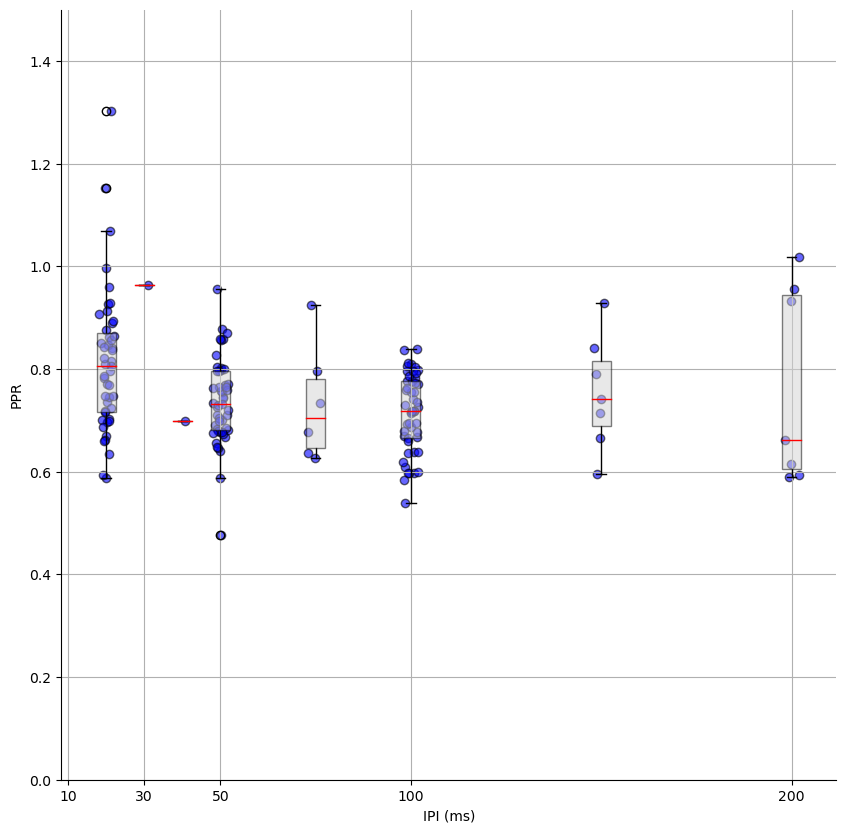

In [7]:
'''# plot histogram of PPR values for each IPI
import matplotlib.pyplot as plt
for ipi in ppr_df['IPI'].unique():
    ipi_df = ppr_df[ppr_df['IPI'] == ipi]
    plt.figure()
    plt.hist(ipi_df['PPR'].dropna(), bins=20, alpha=0.7)
    plt.title(f'Histogram of PPR values for IPI = {ipi} ms')
    plt.xlabel('PPR')
    plt.ylabel('Frequency')
    plt.grid(True)
    plt.show()'''
exclude_10ms = True
if exclude_10ms:
    ppr_df = ppr_df[ppr_df['IPI'] != 10]

# plot scatter plot of PPR vs IPI
import matplotlib.pyplot as plt
plt.figure(figsize=(10, 10))
# average data grouped by Date, Slice, Location, Recording
grouped = ppr_df.groupby(['Date', 'Slice', 'Location', 'Recording']).mean().reset_index()
x_jitter = (np.random.rand(len(grouped)) - 0.5) * 2  # jitter for better visualization

plt.scatter(grouped['IPI'] + x_jitter * 2, grouped['PPR'], alpha=0.6, color='blue', edgecolors='k')
plt.xlabel('IPI (ms)')
plt.ylabel('PPR')
plt.grid(True)
# remove top and right spines
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)

# set y limit to 0 to 2
plt.ylim(0, 4.5)
if exclude_10ms:
    plt.ylim(0, 1.5)

# boxplot overlay of grouped data
plt.boxplot([grouped[grouped['IPI'] == ipi]['PPR'].dropna() for ipi in sorted(grouped['IPI'].unique())],
            positions=sorted(grouped['IPI'].unique()), widths=5, patch_artist=True,
            boxprops=dict(facecolor='lightgray', color='black', alpha=0.5),
            medianprops=dict(color='red'))
# set x ticks to unique IPI values
x_ticks = [10, 30, 50, 100, 200]

plt.xticks(x_ticks, labels=[str(x) for x in x_ticks])
plt.show()

C:\Users\jjudge3\AppData\Local\Temp\ipykernel_25256\2439918041.py:25: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  plt.subplot(1, 2, 1)
C:\Users\jjudge3\AppData\Local\Temp\ipykernel_25256\2439918041.py:31: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  plt.subplot(1, 2, 2)


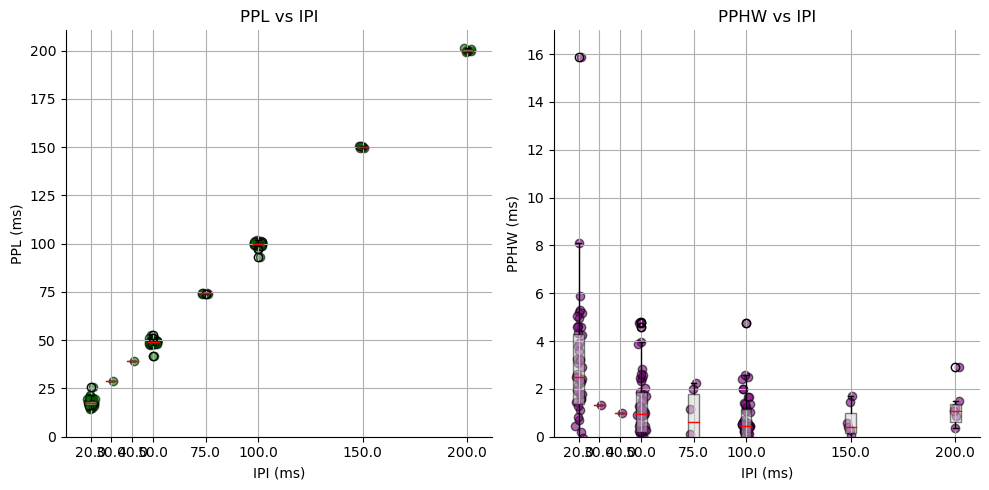

In [ ]:

# plot scatter plot of PPL vs IPI and PPHW vs IPI
import matplotlib.pyplot as plt
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.scatter(grouped['IPI'] + x_jitter * 2, grouped['PPL'], alpha=0.6, color='green', edgecolors='k')
plt.xlabel('IPI (ms)')
plt.ylabel('PPL (ms)')
plt.grid(True)
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)
plt.ylim(0, None)
plt.title('PPL vs IPI')

plt.subplot(1, 2, 2)
plt.scatter(grouped['IPI'] + x_jitter * 2, grouped['PPHW'], alpha=0.6, color='purple', edgecolors='k')
plt.xlabel('IPI (ms)')
plt.ylabel('PPHW (ms)')
plt.grid(True)
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)
plt.ylim(0, None)
plt.title('PPHW vs IPI')

# boxplot overlay of grouped data for PPL
plt.subplot(1, 2, 1)
plt.boxplot([grouped[grouped['IPI'] == ipi]['PPL'].dropna() for ipi in sorted(grouped['IPI'].unique())],
            positions=sorted(grouped['IPI'].unique()), widths=5, patch_artist=True,
            boxprops=dict(facecolor='lightgray', color='black', alpha=0.5),
            medianprops=dict(color='red'))
# boxplot overlay of grouped data for PPHW
plt.subplot(1, 2, 2)
plt.boxplot([grouped[grouped['IPI'] == ipi]['PPHW'].dropna() for ipi in sorted(grouped['IPI'].unique())],
            positions=sorted(grouped['IPI'].unique()), widths=5, patch_artist=True,
            boxprops=dict(facecolor='lightgray', color='black', alpha=0.5),
            medianprops=dict(color='red'))

plt.tight_layout()
plt.show()



In [9]:
# use ttest_ind_from_stats to see if the PPD recovery is significantly differnent
# between medial, lateral, caudal, and rostral
slope_means = {
    
}
slope_stds = {
    
}
intercept_means = {
    
}
intercept_stds = {
}

# number of tests is nC2
num_tests = 6 * 2
# calculate the t-statistic and p-value for each pair of slopes and intercepts

for i1 in range(len(dir)):
    dir1 = dir[i1]
    for i2 in range(i1+1, len(dir)):
        dir2 = dir[i2]
        if dir1 == dir2:
            continue
        slope_tstat, slope_pval = ttest_ind_from_stats(slope_means[dir1], slope_stds[dir1], 10, 
                                                        slope_means[dir2], slope_stds[dir2], 10,
                                                        equal_var=False)
        intercept_tstat, intercept_pval = ttest_ind_from_stats(intercept_means[dir1], intercept_stds[dir1], 10, 
                                                                intercept_means[dir2], intercept_stds[dir2], 10,
                                                                equal_var=False)
        if slope_pval * num_tests < 0.05:
            print(f"\n{dir1} vs {dir2}:")
            print("Slope t-statistic =", round(slope_tstat, 2))
            print("Slope p-value =", slope_pval)
        if intercept_pval * num_tests < 0.05:
            print(f"\n{dir1} vs {dir2}:")
            print("Intercept t-statistic =", round(intercept_tstat, 2))
            print("Intercept p-value =", intercept_pval)

TypeError: object of type 'builtin_function_or_method' has no len()

In [ ]:

def anova_time_constants(data, var='Time_Constant'):
    model = ols(var + ' ~ C(Direction)', data=data).fit()
    anova_results = anova_lm(model, typ=2)
    return anova_results

time_constants_means = {
    "Dorsal": 235,
    "Ventral": 269,
    "Rostral": 110,
}
time_constants_sems = {
    "Dorsal": 150,
    "Ventral": 230,
    "Rostral": 85,
}
time_constants_n = {
    "Dorsal": 7,
    "Ventral": 8,
    "Rostral": 11,
    "Caudal": 8
}
# simulate the data for ANOVA
anova_data = {}
for direction in ['Dorsal', 'Ventral', 'Rostral']:
    mean = time_constants_means[direction]
    sem = time_constants_sems[direction]
    n = time_constants_n[direction]
    # generate random data based on mean and sem
    anova_data[direction] = np.random.normal(mean, sem, n)

anova_df = pd.DataFrame({
    'Time_Constant': np.concatenate(list(anova_data.values())),
    'Direction': ['Dorsal'] * len(anova_data['Dorsal']) + ['Ventral'] * len(anova_data['Ventral']) + ['Rostral'] * len(anova_data['Rostral'])
})

anova_results = anova_time_constants(anova_df)
print(anova_results)

# ttest_ind_from_stats for time constants
for i1 in range(len(time_constants_means)):
    dir1 = list(time_constants_means.keys())[i1]
    for i2 in range(i1+1, len(time_constants_means)):
        dir2 = list(time_constants_means.keys())[i2]
        if dir1 == dir2:
            continue
        time_constant_tstat, time_constant_pval = ttest_ind_from_stats(
            time_constants_means[dir1], time_constants_sems[dir1], time_constants_n[dir1],
            time_constants_means[dir2], time_constants_sems[dir2], time_constants_n[dir2],
            equal_var=False
        )
        print(f"\n{dir1} vs {dir2}:")
        print("Time Constant t-statistic =", round(time_constant_tstat, 2))
        print("Time Constant p-value =", time_constant_pval)

# Tukey's HSD test for multiple comparisons
from statsmodels.stats.multicomp import pairwise_tukeyhsd
tukey = pairwise_tukeyhsd(endog=anova_df['Time_Constant'], groups=anova_df['Direction'], alpha=0.05)
print(tukey)

                     sum_sq    df         F    PR(>F)
C(Direction)   71145.543146   2.0  1.315724  0.287726
Residual      621842.780626  23.0       NaN       NaN

Dorsal vs Ventral:
Time Constant t-statistic = -0.34
Time Constant p-value = 0.7374871585054672

Dorsal vs Rostral:
Time Constant t-statistic = 2.01
Time Constant p-value = 0.07734066184286946

Ventral vs Rostral:
Time Constant t-statistic = 1.86
Time Constant p-value = 0.09741591285023916
   Multiple Comparison of Means - Tukey HSD, FWER=0.05    
 group1  group2  meandiff p-adj    lower    upper   reject
----------------------------------------------------------
 Dorsal Rostral -119.2857 0.3096  -318.335  79.7636  False
 Dorsal Ventral  -29.8211    0.9 -242.8906 183.2485  False
Rostral Ventral   89.4646 0.4833 -101.8311 280.7603  False
----------------------------------------------------------


In [ ]:
ppr_intercepts_means = {
    }

ppr_intercepts_sems = {
    }

ppr_intercepts_n = time_constants_n

# anova for PPR intercepts
anova_ppr_data = {}
for direction in ppr_intercepts_means.keys():
    mean = ppr_intercepts_means[direction]
    sem = ppr_intercepts_sems[direction]
    n = ppr_intercepts_n[direction]
    # generate random data based on mean and sem
    anova_ppr_data[direction] = np.random.normal(mean, sem, n)

anova_ppr_df = pd.DataFrame({
    'PPR_Intercept': np.concatenate(list(anova_ppr_data.values())),
    'Direction': ['Dorsal'] * len(anova_ppr_data['Dorsal']) + 
                 ['Ventral'] * len(anova_ppr_data['Ventral']) + 
                 ['Rostral'] * len(anova_ppr_data['Rostral']) +
                 ['Caudal'] * len(anova_ppr_data['Caudal'])
})
anova_ppr_results = anova_time_constants(anova_ppr_df, var='PPR_Intercept')
print(anova_ppr_results)

# Tukey's HSD test for multiple comparisons
from statsmodels.stats.multicomp import pairwise_tukeyhsd
tukey = pairwise_tukeyhsd(endog=anova_ppr_df['PPR_Intercept'], groups=anova_ppr_df['Direction'], alpha=0.05)
print(tukey)

                sum_sq    df         F   PR(>F)
C(Direction)  0.265812   3.0  8.672689  0.00027
Residual      0.306493  30.0       NaN      NaN
 Multiple Comparison of Means - Tukey HSD, FWER=0.05  
 group1  group2 meandiff p-adj   lower   upper  reject
------------------------------------------------------
 Caudal  Dorsal  -0.2649  0.001 -0.4071 -0.1226   True
 Caudal Rostral  -0.0997 0.1689 -0.2274   0.028  False
 Caudal Ventral  -0.1066 0.1732  -0.244  0.0308  False
 Dorsal Rostral   0.1651 0.0104  0.0322   0.298   True
 Dorsal Ventral   0.1582 0.0247   0.016  0.3005   True
Rostral Ventral  -0.0069    0.9 -0.1346  0.1208  False
------------------------------------------------------


In [ ]:
# 2-way ANOVA for PPR vs IPI and Direction
model = ols('PPR ~ IPI * C(Direction) + IPI:C(Direction)', data=ppr_df).fit()
anova_table = anova_lm(model, typ=2)
anova_table

,sum_sq,df,F,PR(>F)
C(Direction),26.684122,4.0,1.024229,0.393895
IPI,34.623926,1.0,5.315945,0.021437
IPI:C(Direction),84.274532,4.0,3.234748,0.012114
Residual,4350.832117,668.0,NaN,NaN


In [ ]:
# 2-way ANOVA for medial and lateral PPR vs IPI (coronal sections)
model = ols('PPR ~ IPI + C(Medial_Lateral) + IPI:C(Medial_Lateral)', 
                data=ppr_df[(ppr_df['Medial_Lateral'] != 'Home') & (ppr_df['Section'] == 'Coronal')]).fit()
anova_table = anova_lm(model, typ=2)
anova_table

,sum_sq,df,F,PR(>F)
C(Medial_Lateral),5.053844,1.0,2.928850,0.088812
IPI,4.283647,1.0,2.482498,0.116957
IPI:C(Medial_Lateral),15.244388,1.0,8.834567,0.003380
Residual,296.792655,172.0,NaN,NaN


In [ ]:
# 2-way ANOVA for rostral and caudal PPR vs IPI (sagittal sections)
model = ols('PPR ~ IPI + C(Rostral_Caudal) + IPI:C(Rostral_Caudal)', 
                data=ppr_df[(ppr_df['Rostral_Caudal'] != 'Home') & (ppr_df['Section'] == 'Sagittal')]).fit()
anova_table = anova_lm(model, typ=2)
anova_table

,sum_sq,df,F,PR(>F)
C(Rostral_Caudal),0.213399,1.0,0.165003,0.685022
IPI,0.383089,1.0,0.296209,0.586869
IPI:C(Rostral_Caudal),0.542208,1.0,0.419241,0.518051
Residual,261.248197,202.0,NaN,NaN


In [ ]:
# 2-way ANOVA for coronal and sagittal PPR vs IPI (all sections)
model = ols('PPR ~ IPI + C(Section) + IPI:C(Section)', 
                data=ppr_df).fit()
anova_table = anova_lm(model, typ=2)
anova_table

,sum_sq,df,F,PR(>F)
C(Section),38.701646,1.0,5.923185,0.015202
IPI,33.099767,1.0,5.065832,0.024724
IPI:C(Section),19.223988,1.0,2.942181,0.086754
Residual,4403.865136,674.0,NaN,NaN


In [ ]:
# load all_animals_age_sex.csv from C:\Users\jjudge3\Desktop\Data\crossing_PPR\
age_sex_csv = 'C:/Users/jjudge3/Desktop/Data/crossing_PPR/all_animals_age_sex.csv'
age_sex_df = pd.read_csv(age_sex_csv)

# add age and sex as columns to ladder_df_nbqx, matching on Date
# Merge Age and Sex from age_sex_df into ppr_final_df using the Date column
ppr_final_df = ppr_final_df.merge(
    age_sex_df[['Date', 'Age', 'Sex']],
    on='Date',
    how='left',
    suffixes=('', '_from_age_sex')
)
ppr_final_df

,Date,PPR,PPR Composed,IPI,Direction,Section,Age,Sex
0,1/2/2025,2.191522,2.271595,20,Lateral,Coronal,52.0,M
1,1/7/2025,0.550152,0.903302,20,Lateral,Coronal,57.0,M
2,1/7/2025,0.774764,0.968513,20,Lateral,Coronal,57.0,M
3,1/7/2025,0.810284,0.777379,20,Lateral,Coronal,57.0,M
4,11/6/2024,0.483911,0.868049,20,Lateral,Coronal,46.0,M
...,...,...,...,...,...,...,...,...
395,4/9/2025,0.884616,0.827771,130,Rostral,Sagittal,43.0,F
396,4/9/2025,0.926541,0.667876,130,Rostral,Sagittal,43.0,F
397,4/16/2025,0.660833,0.616403,130,Rostral,Sagittal,41.0,F
398,4/16/2025,0.790963,0.590855,130,Rostral,Sagittal,41.0,F


In [ ]:
# ANOVA for age
# 2-way ANOVA for medial and lateral PPR vs IPI (coronal sections)
# make Age_from_age_sex a numerical column
ppr_final_df['Age_from_age_sex'] = pd.to_numeric(ppr_final_df['Age_from_age_sex'], errors='coerce')
model = ols('PPR ~ IPI + Age_from_age_sex + Sex + IPI:Age_from_age_sex + IPI:Sex + Direction', 
                data=ppr_final_df).fit()
anova_table = anova_lm(model, typ=2)
anova_table

KeyError: 'Age_from_age_sex'

Sex: M | Slope: 0.0015 ± 0.0006 | Intercept: 0.6667 ± 0.0536
           Date
0      1/2/2025
1      1/7/2025
4     11/6/2024
5    12/11/2024
7    12/20/2024
14   12/23/2024
184   1/15/2025
188    2/5/2025
Sex: M | n: 8
Sex: F | Slope: 0.0003 ± 0.0007 | Intercept: 0.7934 ± 0.0547
           Date
6    12/18/2024
186   1/22/2025
189    4/9/2025
194   4/16/2025
Sex: F | n: 4


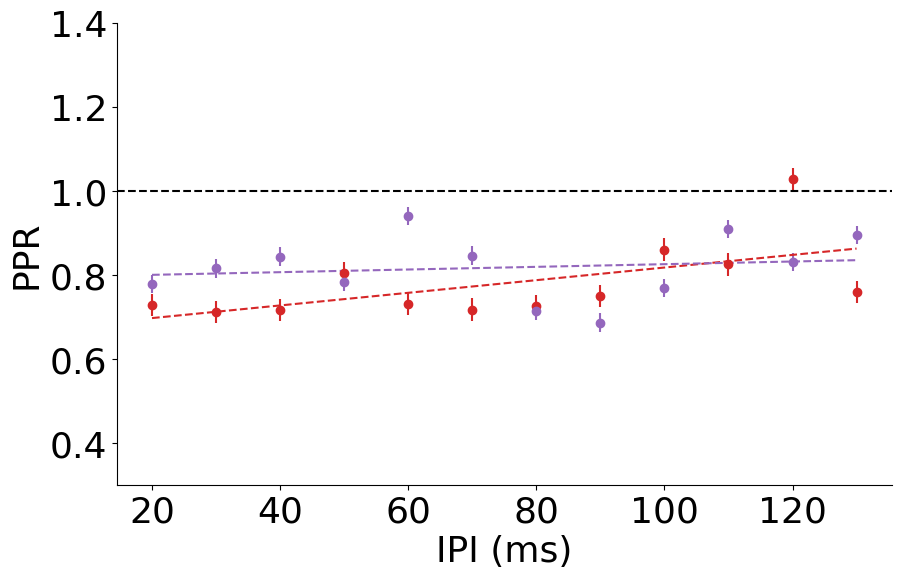

In [ ]:
# Group by Sex and then plot PPR versus IPI.

# Create a new figure for the plot
fig, ax = plt.subplots(figsize=(10, 6))
# Iterate through each unique Sex value
for i_sex, sex in enumerate(ppr_final_df['Sex'].unique()):
    # Filter the DataFrame for the current sex, and for Direction not None
    sex_ppr_df = ppr_final_df[(ppr_final_df['Sex'] == sex)]
    # Group by IPI and calculate the mean PPR for each IPI
    grouped_df = sex_ppr_df.groupby('IPI').mean()
    # Plot the mean PPR versus IPI for the current sex, with error bars
    ax.errorbar(grouped_df.index, grouped_df['PPR'], 
                yerr=grouped_df['PPR'].sem(),
                color='tab:red' if sex == 'M' else 'tab:purple',
                label = sex, fmt='o')

    # linear regression fit
    p0 = (0.1, 0.6)  # initial guess for slope and intercept
    popt, pcov = curve_fit(lambda x, a, b: a * x + b, 
                           grouped_df.index, 
                           grouped_df['PPR'], p0=p0, maxfev=10000)
    # plot the fit line
    x_fit = np.linspace(grouped_df.index.min(), grouped_df.index.max(), 100)
    y_fit = popt[0] * x_fit + popt[1]
    ax.plot(x_fit, y_fit, color='tab:red' if sex == 'M' else 'tab:purple', linestyle='--')
    # print the slope and intercept with uncertainty
    slope_uncertainty = np.sqrt(pcov[0][0])
    intercept_uncertainty = np.sqrt(pcov[1][1])
    print(f"Sex: {sex} | Slope: {popt[0]:.4f} ± {slope_uncertainty:.4f} | Intercept: {popt[1]:.4f} ± {intercept_uncertainty:.4f}")
    
    # print number of animals
    print(sex_ppr_df[['Date']].drop_duplicates())
    n_slices = sex_ppr_df[['Date']].drop_duplicates().shape[0]
    print(f"Sex: {sex} | n: {n_slices}")

#ax.legend()
ax.set_xlabel('IPI (ms)')
ax.set_ylabel('PPR')
ax.set_ylim(0.3, 1.4)

# dotted line at PPR = 1
ax.axhline(1, color='black', linestyle='--')

# remove spines
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

# save the figure
plt.savefig(output_fig_dir + "sex_PPR_vs_IPI.png", dpi=300, bbox_inches='tight')
plt.show()

Age: 45 | Slope: 0.0007 ± 0.0006 | Intercept: 0.7538 ± 0.0495
Age: 45 | n: 9
Age: 60 | Slope: 0.0007 ± 0.0005 | Intercept: 0.6980 ± 0.0384
Age: 60 | n: 2
Age: 30 | Slope: 0.0029 ± 0.0020 | Intercept: 0.6745 ± 0.1627
Age: 30 | n: 1


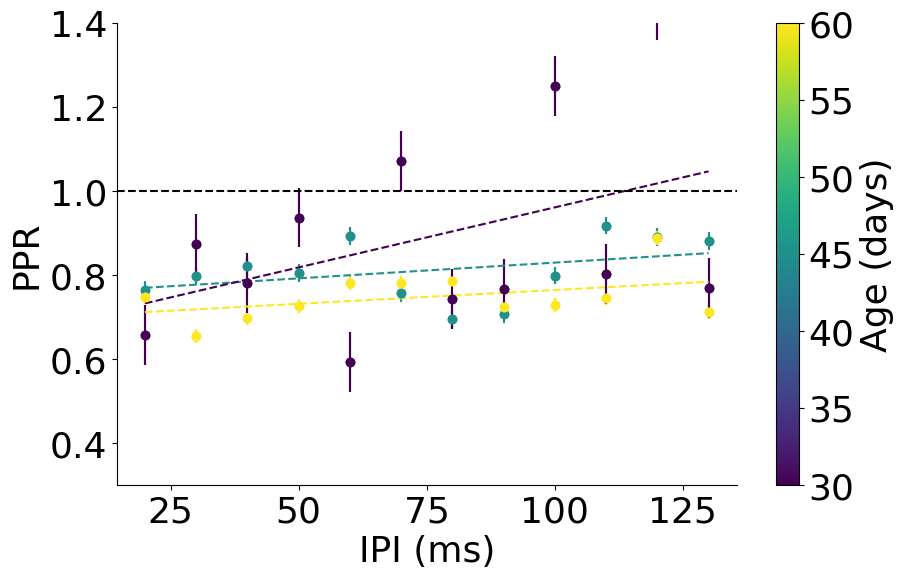

In [ ]:
# Group by Age and then plot PPR versus IPI.

# map ages to the nearest of 30, 45, or 60 days
def map_age_to_nearest(age):
    if age < 37.5:
        return 30
    elif 37.5 < age < 52.5:
        return 45
    elif age > 52.5:
        return 60
    else:
        return 60
# Apply the mapping function to the Age column
ppr_final_df['Age'] = ppr_final_df['Age'].apply(map_age_to_nearest)

# Create a new figure for the plot
fig, ax = plt.subplots(figsize=(10, 6))

# colorbar for age
# Normalize ages for colormap
ages = ppr_final_df['Age'].unique()
ages.sort()
norm = plt.Normalize(ages.min(), ages.max())
cmap = plt.cm.viridis

# Iterate through each unique Sex value
for i_age, age in enumerate(ppr_final_df['Age'].unique()):
    # Filter the DataFrame for the current sex
    age_ppr_df = ppr_final_df[ppr_final_df['Age'] == age]
    # Group by IPI and calculate the mean PPR for each IPI
    grouped_df = age_ppr_df.groupby('IPI').mean()
    # Plot the mean PPR versus IPI for the current sex, with error bars

    # Get color for this age
    color = cmap(norm(age))
    ax.errorbar(grouped_df.index, grouped_df['PPR'], 
                yerr=grouped_df['PPR'].sem(),
                color=color,
                fmt='o')


    ax.errorbar(grouped_df.index, grouped_df['PPR'], 
                yerr=grouped_df['PPR'].sem(),
                color=color,
                 fmt='o')

    # linear regression fit
    p0 = (0.1, 0.6)  # initial guess for slope and intercept
    popt, pcov = curve_fit(lambda x, a, b: a * x + b, 
                           grouped_df.index, 
                           grouped_df['PPR'], p0=p0, maxfev=10000)
    # plot the fit line
    x_fit = np.linspace(grouped_df.index.min(), grouped_df.index.max(), 100)
    y_fit = popt[0] * x_fit + popt[1]
    ax.plot(x_fit, y_fit, color=color, linestyle='--')
    # print the slope and intercept with uncertainty
    slope_uncertainty = np.sqrt(pcov[0][0])
    intercept_uncertainty = np.sqrt(pcov[1][1])
    print(f"Age: {age} | Slope: {popt[0]:.4f} ± {slope_uncertainty:.4f} | Intercept: {popt[1]:.4f} ± {intercept_uncertainty:.4f}")

    # print number of animals
    n_slices = age_ppr_df[['Date']].drop_duplicates().shape[0]
    print(f"Age: {age} | n: {n_slices}")


# Add colorbar to indicate age
sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
sm.set_array([])
cbar = plt.colorbar(sm, ax=ax)
cbar.set_label('Age (days)')

#ax.legend()
ax.set_xlabel('IPI (ms)')
ax.set_ylabel('PPR')
ax.set_ylim(0.3, 1.4)

# dotted line at PPR = 1
ax.axhline(1, color='black', linestyle='--')

# remove spines
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

# save the figure
plt.savefig(output_fig_dir + "age_PPR_vs_IPI.png", dpi=300, bbox_inches='tight')
plt.show()

In [ ]:
# use ttest_ind_from_stats to see if PPR linear regression slopes/intercepts are significantly different
# in age groups or between sexes

'''Age: 45 | Slope: 0.0007 ± 0.0006 | Intercept: 0.7538 ± 0.0495
Age: 45 | n: 9
Age: 60 | Slope: 0.0007 ± 0.0005 | Intercept: 0.6980 ± 0.0384
Age: 60 | n: 2
Age: 30 | Slope: 0.0029 ± 0.0020 | Intercept: 0.6745 ± 0.1627
Age: 30 | n: 1'''

slope_means = {
    'M': 0.0015,
    'F': 0.0003,
    '30': 0.0029,
    '45': 0.0007,
    '60': 0.0007,
}
slope_stds = {
    'M': 0.0006,
    'F': 0.0007,
    '30': 0.0020,
    '45': 0.0006,
    '60': 0.0005,
}
intercept_means = {
    'M': 0.6667,
    'F': 0.7934,
    '30': 0.6745,
    '45': 0.7538,
    '60': 0.6980
}
intercept_stds = {
    'M': 0.0536,
    'F': 0.0547,
    '30': 0.1627,
    '45': 0.0495,
    '60': 0.0384
}

sample_sizes = {
    'M': 8,
    'F': 4,
    '30': 1,
    '45': 9,
    '60': 2
}


# calculate the t-statistic and p-value for each pair of slopes and intercepts
slope_tstat, slope_pval = ttest_ind_from_stats(slope_means['M'], slope_stds['M'], sample_sizes['M'], 
                                                slope_means['F'], slope_stds['F'], sample_sizes['F'],
                                                equal_var=False)
intercept_tstat, intercept_pval = ttest_ind_from_stats(intercept_means['M'], intercept_stds['M'], sample_sizes['M'], 
                                                        intercept_means['F'], intercept_stds['F'], sample_sizes['F'],
                                                        equal_var=False)
print(f"\nM vs F:")
print("Slope t-statistic =", round(slope_tstat, 2))
print("Slope p-value =", slope_pval)
print("Intercept t-statistic =", round(intercept_tstat, 2))
print("Intercept p-value =", intercept_pval)


# calculate the t-statistic and p-value for each pair of slopes and intercepts
ages = ['45', '60']
for i1 in range(len(ages)):
    age1 = ages[i1]
    for i2 in range(i1+1, len(ages)):
        age2 = ages[i2]
        if age1 == age2:
            continue
        slope_tstat, slope_pval = ttest_ind_from_stats(slope_means[age1], slope_stds[age1], sample_sizes[age1], 
                                                        slope_means[age2], slope_stds[age2], sample_sizes[age2],
                                                        equal_var=False)
        intercept_tstat, intercept_pval = ttest_ind_from_stats(intercept_means[age1], intercept_stds[age1], sample_sizes[age1], 
                                                                intercept_means[age2], intercept_stds[age2], sample_sizes[age2],
                                                                equal_var=False)
        print(f"\n{age1} vs {age2}:")
        print("Slope t-statistic =", round(slope_tstat, 2))
        print("Slope p-value =", slope_pval)
        print("Intercept t-statistic =", round(intercept_tstat, 2))
        print("Intercept p-value =", intercept_pval)



M vs F:
Slope t-statistic = 2.93
Slope p-value = 0.030341537691595647
Intercept t-statistic = -3.81
Intercept p-value = 0.00893911659477698

45 vs 60:
Slope t-statistic = 0.0
Slope p-value = 1.0
Intercept t-statistic = 1.76
Intercept p-value = 0.2316490621613208


## 